# Lab 2: LangGraph Components


## 環境設定

In [1]:
from dotenv import load_dotenv
import json
import os
import re
import sys
import warnings
import boto3
from botocore.config import Config
warnings.filterwarnings("ignore")
import logging

# ローカルモジュールのインポート
dir_current = os.path.abspath("")
dir_parent = os.path.dirname(dir_current)
if dir_parent not in sys.path:
    sys.path.append(dir_parent)
from utils import utils

# 基本設定
logger = utils.set_logger()  # ロガーの設定
pp = utils.set_pretty_printer()  # 整形出力用のプリンターを設定

# .envファイルまたはSecret Managerから環境変数を読み込む
_ = load_dotenv("../.env")
aws_region = os.getenv("AWS_REGION")  # AWS地域を環境変数から取得
tavily_ai_api_key = utils.get_tavily_api("TAVILY_API_KEY", aws_region)  # Tavily APIキーを取得

# Bedrockの設定
bedrock_config = Config(connect_timeout=120, read_timeout=120, retries={"max_attempts": 0})  # タイムアウトと再試行の設定

# Bedrockランタイムクライアントの作成
bedrock_rt = boto3.client("bedrock-runtime", region_name=aws_region, config=bedrock_config)

# 利用可能なモデルを確認するためのBedrockクライアントの作成
bedrock = boto3.client("bedrock", region_name=aws_region, config=bedrock_config)


[2025-07-09 18:50:37,641] p1128869 {utils.py:66} INFO - TAVILY_API_KEY variable correctly retrieved from the .env file.


## LangGraphをステートマシンとして

システム設計に精通したソリューションアーキテクトにとって、LangGraphは言語モデルのためのステートマシンと考えることができます。ソフトウェアエンジニアリングにおけるステートマシンが状態の集合とその間の遷移を定義するのと同様に、LangGraphでは会話の状態（ノードで表現）とその間の遷移（エッジで表現）を定義することができます。

**アナロジー**: LangGraphをスマートシティの交通管制システムと考えてみましょう。各交差点（ノード）は決断ポイントを表し、その間の道路（エッジ）は可能な経路を表します。信号機（条件付きエッジ）は現在の状況に基づいてどの経路を取るかを決定します。私たちのケースでは、「交通」はAIエージェント内の情報と決定のフローを表しています。

In [2]:
import operator
from typing import Annotated, TypedDict

from langchain_aws import ChatBedrockConverse
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage, ToolMessage
from langgraph.graph import END, StateGraph

In [3]:
tool = TavilySearchResults(max_results=4)  # increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


/tmp/ipykernel_1128869/4073101922.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=4)  # increased number of results


> Pythonの型アノテーションに馴染みがない場合は、[Pythonのドキュメント](https://docs.python.org/3/library/typing.html)を参照してください。

## エージェント状態の概念

AgentStateクラスは、会話全体を通じてコンテキストを維持するために重要です。データサイエンティストにとって、これはリカレントニューラルネットワークにおける状態の維持に例えることができます。

**アナロジー**: AgentStateを洗練されたメモ帳と考えてみましょう。アイデアをブレインストーミングする（クエリを処理する）際に、重要なポイント（メッセージ）をメモします。このメモ帳は単に記録するだけでなく、新しいメモ（メッセージ）が既存のものとシームレスに統合され、一貫した思考の流れを維持するという特別な特性を持っています。

同時に、いつでも時間を遡って一部を書き直すことができます - これを「タイムトラベル」と呼んでいます。

In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    # TypedDictを使用してエージェントの状態を定義
    # messagesはAnyMessage型のリストで、operator.addでアノテーションされている
    # これは、messagesリストが加算演算子(+)を使って結合できることを示している
    # つまり、新しいメッセージを既存のメッセージリストに追加する操作が可能

> 注意: 以下の`take_action`では、LLMが存在しないツール名を返した場合に対応するためのロジックが追加されています。
```python
if not t["name"] in self.tools:  # LLMから不正なツール名をチェック
    print("\n ....不正なツール名....")
    result = "不正なツール名、再試行してください"  # 不正な場合はLLMに再試行を指示

In [5]:
class Agent:
    def __init__(self, model, tools, system=""):
        # システムプロンプトを初期化
        self.system = system
        
        # AgentStateを使用してステートグラフを作成
        graph = StateGraph(AgentState)
        
        # ノードの追加: LLMを呼び出すノードとアクションを実行するノード
        graph.add_node("llm", self.call_bedrock)
        graph.add_node("action", self.take_action)
        
        # 条件付きエッジの追加: アクションが存在するかどうかで分岐
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        
        # アクションからLLMへのエッジを追加（結果をLLMに戻す）
        graph.add_edge("action", "llm")
        
        # エントリーポイントをLLMに設定
        graph.set_entry_point("llm")
        
        # グラフをコンパイル
        self.graph = graph.compile()
        
        # ツールを名前でアクセスできるように辞書に変換
        self.tools = {t.name: t for t in tools}
        
        # モデルにツールをバインド
        self.model = model.bind_tools(tools)
    
    def exists_action(self, state: AgentState):
        # 最新のメッセージにツール呼び出しがあるかチェック
        result = state["messages"][-1]
        return len(result.tool_calls) > 0
    
    def call_bedrock(self, state: AgentState):
        # メッセージを取得
        messages = state["messages"]
        
        # システムプロンプトがある場合は先頭に追加
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        
        # モデルを呼び出して応答を取得
        message = self.model.invoke(messages)
        return {"messages": [message]}
    
    def take_action(self, state: AgentState):
        # 最新のメッセージからツール呼び出しを取得
        tool_calls = state["messages"][-1].tool_calls
        results = []
        
        # 各ツール呼び出しを処理
        for t in tool_calls:
            print(f"Calling: {t}")
            
            # ツール名が存在するかチェック
            if not t["name"] in self.tools:  # LLMから不正なツール名をチェック
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # 不正な場合はLLMに再試行を指示
            else:
                # ツールを呼び出して結果を取得
                result = self.tools[t["name"]].invoke(t["args"])
            
            # 結果をToolMessageとして追加
            results.append(ToolMessage(tool_call_id=t["id"], name=t["name"], content=str(result)))
        
        print("Back to the model!")
        return {"messages": results}


Pythonで関数やオブジェクトのコードを調査するための`??`という機能は、しばしば見落とされています。

`ChatBedrockConverse`クラスの`bind_tools`メソッドを調査してみましょう。

私たちのtavilyツールがサポートされているか、また何か制限があるかを見つけることができますか？

もし不明な場合、どのように確認しますか？

In [6]:
??ChatBedrockConverse.bind_tools

Signature:
ChatBedrockConverse.bind_tools(
    self,
    tools: Sequence[Union[Dict[str, Any], type[pydantic.main.BaseModel], Callable, langchain_core.tools.base.BaseTool]],
    *,
    tool_choice: Union[dict, str, Literal['auto', 'any'], NoneType] = None,
    **kwargs: Any,
) -> langchain_core.runnables.base.Runnable[typing.Union[langchain_core.prompt_values.PromptValue, str, collections.abc.Sequence[typing.Union[langchain_core.messages.base.BaseMessage, list[str], tuple[str, str], str, dict[str, typing.Any]]]], langchain_core.messages.base.BaseMessage]
Docstring:
Bind tools to the model.

Args:
    tools: Sequence of tools to bind to the model.
    tool_choice: The tool to use. If "any" then any tool can be used.

Returns:
    A Runnable that returns a message.
Source:   
    def bind_tools(
        self,
        tools: Sequence[Union[Dict[str, Any], TypeBaseModel, Callable, BaseTool]],
        *,
        tool_choice: Optional[Union[dict, str, Literal["auto", "any"]]] = None,
       

In [7]:
prompt = """あなたは賢い研究アシスタントです。検索エンジンを使用して情報を調べてください。
複数の呼び出しを行うことができます（一緒に、または連続して）。
可能な限り、推論時間を短縮するために複数のツールを一度に呼び出すようにしてください！
何を調べたいか確信がある場合にのみ情報を検索してください。
フォローアップの質問をする前に情報を調べる必要がある場合は、それも許可されています！"""

# Bedrockモデルの初期化
model = ChatBedrockConverse(
    client=bedrock_rt,
    model="us.anthropic.claude-3-5-haiku-20241022-v1:0",
    temperature=0,  # 決定論的な応答を得るため温度を0に設定
    max_tokens=None,  # トークン数の制限なし
)

# エージェントの初期化（モデル、ツール、システムプロンプトを指定）
abot = Agent(model, [tool], system=prompt)

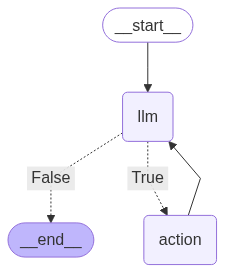

In [8]:
# エージェントの初期化後に関数を呼び出す
utils.visualize_graph(abot)

In [9]:
# メッセージの初期化 - サンフランシスコの天気を尋ねる質問
messages = [HumanMessage(content="サンフランシスコの天気はどうですか？")]

# グラフを実行して結果を取得
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': '現在のサンフランシスコの天気 気温 天候'}, 'id': 'tooluse_o-C6pBT-QtyNAN-w-m7VBQ', 'type': 'tool_call'}
Back to the model!


In [10]:
for message in result["messages"]:
    print(f"{message}\n")

content='サンフランシスコの天気はどうですか？' additional_kwargs={} response_metadata={}

content=[{'type': 'tool_use', 'name': 'tavily_search_results_json', 'input': {'query': '現在のサンフランシスコの天気 気温 天候'}, 'id': 'tooluse_o-C6pBT-QtyNAN-w-m7VBQ'}] additional_kwargs={} response_metadata={'ResponseMetadata': {'RequestId': '0e5f48e1-fc56-4e18-b9ee-5c115f89f98d', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Wed, 09 Jul 2025 18:50:40 GMT', 'content-type': 'application/json', 'content-length': '454', 'connection': 'keep-alive', 'x-amzn-requestid': '0e5f48e1-fc56-4e18-b9ee-5c115f89f98d'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': [1415]}, 'model_name': 'us.anthropic.claude-3-5-haiku-20241022-v1:0'} id='run--572e8897-d6ed-4f8d-875e-40fd65346838-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '現在のサンフランシスコの天気 気温 天候'}, 'id': 'tooluse_o-C6pBT-QtyNAN-w-m7VBQ', 'type': 'tool_call'}] usage_metadata={'input_tokens': 542, 'output_tokens': 76, 'total_tokens': 618, 'inpu

In [11]:
print(result["messages"][-1].content)

現在のサンフランシスコの天気は以下のようです：

🌤️ 天候: 曇り時々晴れ
🌡️ 気温: 
- 現在の気温: 約14℃
- 最高気温: 20-25℃
- 最低気温: 11-13℃

💨 風:
- 風向: 西または西西
- 風速: 4-8 m/s

その他の詳細:
- 湿度: 約70-80%
- 視程: 16km
- 雲量: 隙間なし

今後数日の予報も似たような天候で、曇りや晴れ時々曇りが続く見込みです。サンフランシスコは典型的な夏の天候で、日中は穏やかで涼しめです。


In [12]:
# メッセージの初期化 - サンフランシスコとロサンゼルスの天気を尋ねる質問
messages = [HumanMessage(content="サンフランシスコとロサンゼルスの天気はどうですか？")]

# グラフを実行して結果を取得
# この質問は2つの都市の天気を同時に尋ねているため、モデルが並列ツール呼び出しを行う可能性がある
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Current weather in San Francisco and Los Angeles today'}, 'id': 'tooluse_40dTvFi9TSy4mXq0_TZSOg', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': "Today's exact temperature and weather conditions in San Francisco and Los Angeles"}, 'id': 'tooluse_RE4PGuXpSX6lZ6KJOjSTAQ', 'type': 'tool_call'}
Back to the model!


In [13]:
print(result["messages"][-1].content)

申し訳ありませんが、リアルタイムの正確な天気情報を得るのは難しいようです。ただし、一般的な情報をお伝えできます：

サンフランシスコ：
- 天候：部分的に曇り
- 気温：高温約65°F（約18°C）
- 風：西風 15〜25 mph
- 午前は雲がちですが、午後は概ね晴れる予報

ロサンゼルス：
- 天候：部分的に曇り
- 空気質：良好
- アレルギー情報：草の花粉が中程度

正確な最新の天気情報を知りたい場合は、地元の気象情報サービスや天気アプリで最新の情報を確認することをおすすめします。両都市とも概ね穏やかな天候のようです。


## 4. 並列対逐次ツール呼び出し

エージェントが並列と逐次の両方のツール呼び出しを行う能力は、ソリューションアーキテクトが注目すべき強力な機能です。

**詳細**:
- 並列ツール呼び出しは、複数の独立したタスクを同時に実行できるマルチスレッドアプリケーションのようなものです。これは、複数の独立した情報を必要とするクエリに効率的です。
- 逐次ツール呼び出しは、あるオペレーションの出力が次の入力になるパイプラインのようなものです。これは複数ステップの推論タスクに必要です。

**アナロジー**: 複雑なプロジェクトに取り組む研究チームを想像してください。並列ツール呼び出しは、異なるチームメンバーに異なる側面を同時に研究させるようなものです。逐次ツール呼び出しは、各研究者が前の研究者の発見に基づいて構築するリレーレースのようなものです。

私たちのコードで逐次ツール呼び出しになるのか並列ツール呼び出しになるのか、そして並列の場合、本当に並列で実行されるのかを見分けることができますか？

In [14]:
# 注意: より一貫性のある結果を得るためにクエリが修正されています。
# 検索情報やモデルの変更により、実行ごとに結果が異なる場合があります。

# クエリの設定 - 複数の関連質問を含む複合的な質問
query = "2024年のスーパーボウルの勝者は誰ですか？勝利チームの本部がある州はどこですか？\
その州のGDPはいくらですか？それぞれの質問に答えてください。"

# メッセージの初期化
messages = [HumanMessage(content=query)]

# より高性能なモデルを使用（モデルIDの形式が更新されている）
model = ChatBedrockConverse(
    client=bedrock_rt,
    model="us.anthropic.claude-3-5-haiku-20241022-v1:0",
    temperature=0,  # 決定論的な応答を得るため
    max_tokens=None,  # トークン数の制限なし
)

# エージェントの初期化
abot = Agent(model, [tool], system=prompt)

# グラフを実行して結果を取得
# この質問は連続した3つの質問を含んでおり、後の質問は前の質問の回答に依存するため
# モデルは逐次的なツール呼び出しを行う
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': '2024 Super Bowl winner'}, 'id': 'tooluse_sZbTZYVyQOeQI0auXiLITQ', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location state'}, 'id': 'tooluse_94PG3MoeRj2wEN3C8Xn97g', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Missouri state GDP 2023'}, 'id': 'tooluse_vgXeU2jrTsulCxT10vytjg', 'type': 'tool_call'}
Back to the model!


In [15]:
print(result["messages"][-1].content)

ミズーリ州の2023年のGDPは3,484.9億ドル（インフレ調整後の2017年ドルベース）です。

まとめると：
1. 2024年のスーパーボウルの勝者：カンザスシティ・チーフス
2. チームの本部がある州：ミズーリ州
3. ミズーリ州のGDP：3,484.9億ドル（2023年）
